In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\MEHEDI~1\AppData\Local\Temp/ipykernel_3764/4011320681.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [4]:
nPerClust = 300
blur = 1

A = [1,1]
B = [5,1]
C = [4,3]

a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

labels_np = np.hstack(( np.zeros((nPerClust)),
                      np.ones((nPerClust)),
                      1+np.ones((nPerClust))))
data_np = np.hstack((a,b,c)).T

In [6]:
labels_np.shape

(900,)

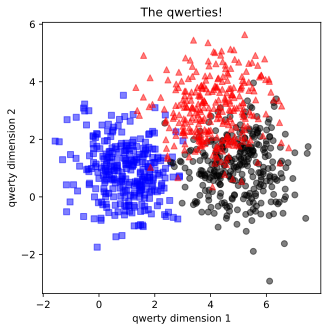

In [7]:
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()

fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [10]:
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=.2)

train_dataset = TensorDataset(train_data,train_labels)
test_dataset = TensorDataset(test_data,test_labels)

batchsize = 16

train_loader = DataLoader(train_dataset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader = DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])

In [9]:
def createTheQwertyNet(optimizerAlgo,learningrate):
    
    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input = nn.Linear(2,8)
            self.fc1 = nn.Linear(8,8)
            self.output = nn.Linear(8,3)
            
        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            return self.output(x)
        
    net = qwertyNet()
    
    lossfun = nn.CrossEntropyLoss()
    
    optifun = getattr(torch.optim,optimizerAlgo)
    optimizer = optifun(net.parameters(),lr = learningrate)
    
    return net,lossfun,optimizer

In [16]:


def funtion2trainTheModel(optimizerType,learningrate):

  
  numepochs = 50
  
  
  net,lossfun,optimizer = createTheQwertyNet(optimizerType,learningrate)

  
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  
  for epochi in range(numepochs):

    
    net.train()

    
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      
      yHat = net(X)
      loss = lossfun(yHat,y)

      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      
      batchLoss.append(loss.item())

      
      matches = torch.argmax(yHat,axis=1) == y     
      matchesNumeric = matches.float()             
      accuracyPct = 100*torch.mean(matchesNumeric) 
      batchAcc.append( accuracyPct )

    trainAcc.append( np.mean(batchAcc) )

    losses[epochi] = np.mean(batchLoss)

    net.eval()
    X,y = next(iter(test_loader)) 
    with torch.no_grad(): 
      yHat = net(X)
      
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) ) 
  
  return trainAcc,testAcc,losses,net


In [ ]:

learningRates = np.logspace(np.log10(.0001),np.log10(.1),20)
optimTypes = ['SGD','RMSprop','Adam']

finalPerformance = np.zeros((len(learningRates),len(optimTypes)))


for idx_o,opto in enumerate(optimTypes):
  for idx_l,lr in enumerate(learningRates):
    trainAcc,testAcc,losses,net = funtion2trainTheModel(opto,lr)
    finalPerformance[idx_l,idx_o] = np.mean(testAcc[-10:])